In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))

stoi = {s: i for i, s in enumerate(('.', *chars))}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [6]:
block_size = 3

def build_dataset(words, block_size):
    X, Y = [], []

    for w in words:
        #print(w)
        context = [stoi['.']] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', ch)
            context = context[1:] + [ix]

    return tf.convert_to_tensor(X), tf.convert_to_tensor(Y)


n1, n2 = int(len(words)*0.8), int(len(words)*0.9)

random.seed(42)
random.shuffle(words)

X_train, Y_train = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_test, Y_test = build_dataset(words[n2:], block_size)

In [7]:
n_embd = 10
n_hidden = 200

tf.random.set_seed(314159)
C = tf.Variable(tf.random.normal((vocab_size, n_embd)), name='C')
W1 = tf.Variable(tf.random.normal((n_embd * block_size, n_hidden)), name='W1')
b1 = tf.Variable(tf.zeros(n_hidden, dtype=tf.float32), name='b1')
W2 = tf.Variable(tf.random.normal((n_hidden, vocab_size)), name='W2')
b2 = tf.Variable(tf.zeros(vocab_size, dtype=tf.float32), name='b2')

parameters = [C, W1, b1, W2, b2]

print(sum(map(tf.size, parameters)).numpy())

def eval_logits(X):
    emb = tf.gather(C, X)
    embcat = tf.reshape(emb, (-1, n_embd * block_size))
    hpreact = embcat @ W1 + b1
    h = tf.math.tanh(hpreact)
    logits = h @ W2 + b2
    return logits


def eval_loss(X, Y):
    logits = eval_logits(X)
    loss = tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(Y, logits, from_logits=True))
    return loss

11897


In [8]:
max_steps = 50000
batch_size = 32
lossi = []
learning_rate = tf.Variable(1.0, trainable=False)


def apply_gradient(param, grad):
    if isinstance(grad, tf.IndexedSlices):
        sub_value = tf.IndexedSlices(grad.values * learning_rate, grad.indices)
        param.scatter_sub(sub_value)
    else:
        param.assign_sub(learning_rate*grad)

    
#@tf.function
def train_step(X, Y):
    with tf.GradientTape() as tape:
        loss = eval_loss(X, Y)
    
    for p, dl_dp in zip(parameters, tape.gradient(loss, parameters)):
        apply_gradient(p, dl_dp)
        
    
    return loss


for i in range(max_steps):
    batch_ix = tf.random.uniform(shape=(batch_size,), minval=0, maxval=X_train.shape[0], dtype=tf.int32)
    X_batch = tf.gather(X_train, batch_ix)
    Y_batch = tf.gather(Y_train, batch_ix)

    learning_rate.assign(0.1 if i < 25000 else 0.01)
    loss = train_step(X_batch, Y_batch)

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss:.4f}')
    
    lossi.append(loss.numpy())


print(f'train = {eval_loss(X_train, Y_train).numpy()}, dev = {eval_loss(X_dev, Y_dev).numpy()}')


# GPU tf.function 2m 41.1s
#       0/  50000: 20.9121
#   10000/  50000: 2.8837
#   20000/  50000: 2.7365
#   30000/  50000: 2.3199
#   40000/  50000: 2.1650
# train = 2.235541820526123, dev = 2.2479124069213867

# GPU 6m 28.3s
#       0/  50000: 20.9121
#   10000/  50000: 2.6651
#   20000/  50000: 3.0500
#   30000/  50000: 2.2324
#   40000/  50000: 2.2293
# train = 2.230128049850464, dev = 2.247608184814453

# CPU tf.function 1m 15.2s
#       0/  50000: 20.9145
#   10000/  50000: 2.8312
#   20000/  50000: 2.8314
#   30000/  50000: 2.2068
#   40000/  50000: 2.1879
# train = 2.228890895843506, dev = 2.2412242889404297

# CPU


      0/  50000: 20.9145
  10000/  50000: 2.8312
  20000/  50000: 2.8314
  30000/  50000: 2.2068
  40000/  50000: 2.1879
train = 2.228890895843506, dev = 2.2412242889404297


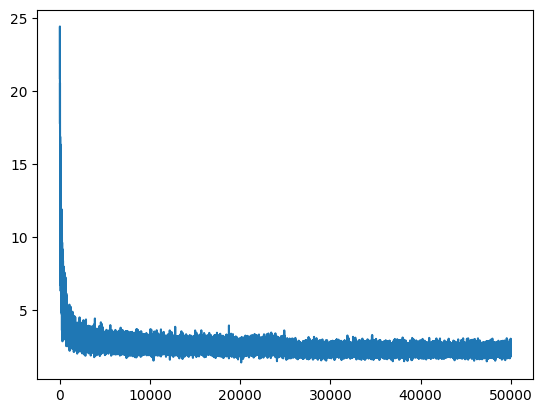

In [9]:
plt.plot(lossi)

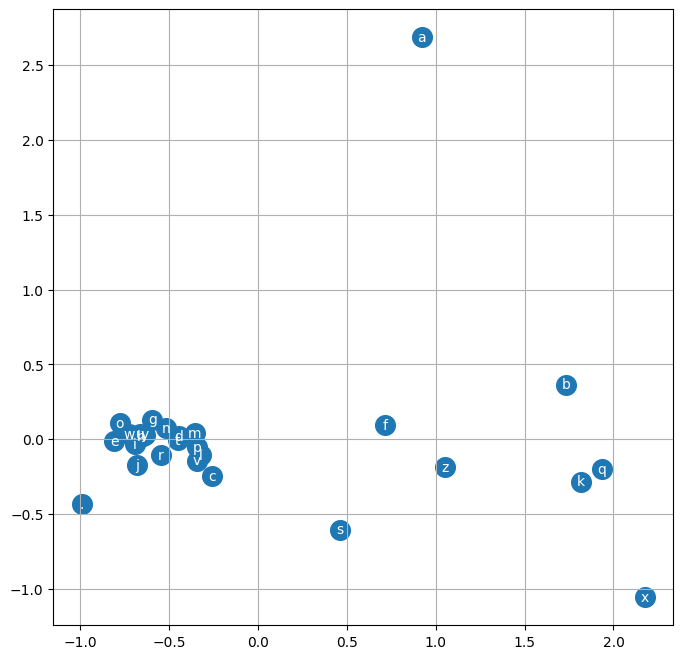

In [10]:
emb_2d = PCA(n_components=2).fit_transform(C.numpy())

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=200)
for i in range(C.shape[0]):
    plt.text(emb_2d[i,0], emb_2d[i,1], itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [11]:
# batch generate examples

gen_batch_size = 10
gen_target = 20

gen_count = 0
start_context = tf.zeros((gen_batch_size, block_size), dtype=tf.int32)
context = start_context
out = [[] for _ in range(gen_batch_size)]

while gen_count < gen_target:
    logits = eval_logits(context)
    next_one_hot = tfp.distributions.Multinomial(1, logits=logits).sample()
    next_ix = tf.argmax(next_one_hot, axis=1, output_type=tf.int32)

    reset = []
    for con_i, (o, i) in enumerate(zip(out, next_ix)):
        o.append(itos[i.numpy()])
        if i == 0:
            print(''.join(o))
            o.clear()
            gen_count += 1
            reset.append([con_i])


    context = tf.concat([context[:, 1:], tf.reshape(next_ix, (-1, 1))], axis=1)

    # context might have rows like [5, 10, 0] which will cause the nn to produce
    # nonsence, 
    if len(reset) > 0:
        context = tf.tensor_scatter_nd_update(
            context,
            reset, 
            start_context[:len(reset), :]
        )

pry.
elia.
ment.
kalyn.
celmi.
hinkl.
amelin.
silveni.
raeyriah.
dakafina.
rae.
frurlao.
cherrnyn.
beys.
kere.
majtolyn.
edraleida.
shellanda.
ahjaigan.
brishan.
